# Introduction to Simulation‑Based Inference

Simulation‑based inference (SBI) refers to a collection of Bayesian methods for estimating the posterior distribution of model parameters when the likelihood function is intractable, but synthetic data can be generated. 

SBI tools such as the `sbi` Python package automate the process of learning the mapping from observed data back to model parameters using neural density estimators.

## Why SBI?

In many scientific domains, simulators provide high‑fidelity models of complex processes. 

These simulators take parameters 𝜃 as input and produce synthetic data 𝑥. However, the likelihood of observing a particular dataset given a set of parameters is often mathematically intractable. 

SBI bypasses this issue by repeatedly simulating data for parameters drawn from a prior distribution and training a neural network to learn the relationship between the data and parameters.

## Algorithms

The `sbi` toolkit implements several families of algorithms:

* **Neural Posterior Estimation (NPE)**: Directly approximates the posterior distribution using neural density estimators.
* **Neural Likelihood Estimation (NLE)**: Learns an approximate likelihood model which is combined with Markov Chain Monte Carlo (MCMC) to sample from the posterior.
* **Neural Ratio Estimation (NRE)**: Estimates the likelihood ratio between parameter values and uses it in an MCMC scheme.

For most tasks in this workshop we will use NPE because it provides an amortized posterior that can be evaluated for many observations without retraining.

## Simple example: 
use NPE in SBI to learn a posterior distribution from simulated parameter–data pairs and visualize the inferred parameter uncertainty for a simple linear-Gaussian model.


In [1]:
from sbi.inference import NPE
from sbi.analysis import pairplot
import torch
from sbi.utils import BoxUniform
_ = torch.manual_seed(0)

In [2]:
num_dim = 3
def simulator(theta):
    # Linear Gaussian.
    return theta + 1.0 + torch.randn_like(theta) * 0.1

prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))
inference = NPE(prior=prior)

num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta)

print("theta.shape", theta.shape)
print("x.shape", x.shape)

theta.shape torch.Size([2000, 3])
x.shape torch.Size([2000, 3])


In [3]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 62 epochs.

In [4]:
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [5]:
x_obs = torch.as_tensor([0.8, 0.6, 0.4])
samples = posterior.sample((10000,), x=x_obs)

  0%|          | 0/10000 [00:00<?, ?it/s]

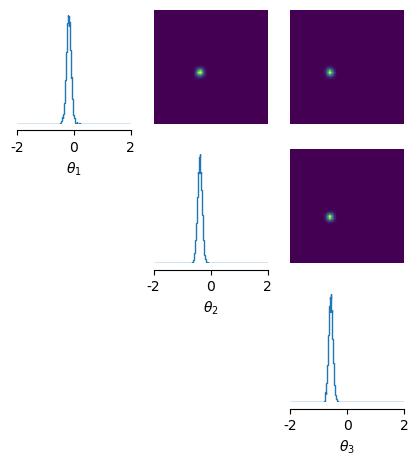

In [6]:
_ = pairplot(
    samples,
    limits=[[-2, 2], [-2, 2], [-2, 2]],
    figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
)